# RAISE.OSIA.IMAGE: ADVANCED PROCESSING

In [ ]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

### Instructions

This assignment is to be completed individually or in pairs. A report is expected and must be submitted to the designated repository in MLS by the end of the second slot on October 14 at 5 p.m.</br>
The expected document is a Notebook or code+pdf report, the evaluation will take into account:
- use the image processing tools covered in class,
- illustration of results with visualization tools,
- take a step back and analyze the results.

### Objectives

The objectives of this practical assignment are multiple:
- to develop a lossy image compression algorithm that offers the best compromise between compression ratio and distortion
- to use basic ML methods to classify images based on well chosen features

1. Starting from a series of images in PPM format, propose a unique algorithm that allows all these images to be compressed with loss
while controlling distortion.
    1. Helps:
        1. Color spaces don't have same dynamics, use `np.clip()`, `.astype(np.uint8)` $\dots$
        1. You can use the dct: `from scipy.fftpack import dct` the direct DCT is `type=2`, the inverse DCT is `type=3`, to be fully reversible use `norm="ortho"`. Don't forget DCT is separable!
        1. You must save your compressed image in binary file not using image file format (JPEG, PNG, otherwise you will recompress it), use pickle!
        1. Don't try to save floating point numbers, to have better coding (without using Huffman code for instance) use `np.int16` for 16 bit unsigned integer for instance
    1. Illustrates your parameters tuning with plots and compare it with JPEG compression,  compression rate (original image size/ compressed image size in bits) vs. distortion PSNR, $\dots$
        1. The byte size of a file can be computed using `os.path.getsize("/path/to/myfile")`

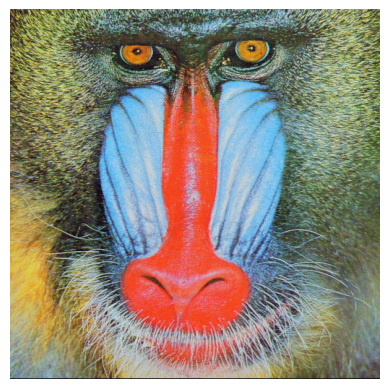

In [ ]:
import imageio.v3 as iio
from scipy.fftpack import dct, idct


# Leer imagen en formato PPM
image = io.imread("/content/Baboon.512.ppm")
img = np.array(image)
# Mostrarla
plt.imshow(img)
plt.axis("off")  # quitar ejes
plt.show()

Paso a formato YCbCr

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

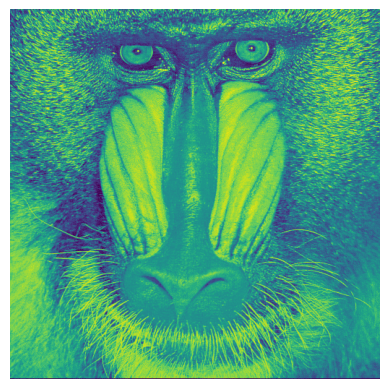

In [ ]:
from skimage.color import rgb2ycbcr, ycbcr2rgb
img_ycbcr = rgb2ycbcr(img)
plt.imshow(img_ycbcr[:,:,0])
plt.axis('off')

In [170]:
from scipy.fftpack import dct, idct

def dct2(block):
    return dct(dct(block.T, norm='ortho', type=2).T,norm='ortho', type=2)

def idct2(block):
    return dct(dct(block.T, norm='ortho', type=3).T,norm='ortho', type=3)


def block_dct(channel, q, block_size=8):
    h, w = channel.shape
    dct_blocks = np.zeros_like(channel, dtype=np.float32)
    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = channel[i:i+block_size, j:j+block_size]
            block = block - 125
            dct_block = dct2(block)
            quantized_block = np.round(dct_block / q)
            dct_blocks[i:i+block_size, j:j+block_size] = quantized_block

    return dct_blocks

def block_idct(dct_blocks, q, block_size=8):
    h, w = dct_blocks.shape
    image = np.zeros_like(dct_blocks, dtype=np.float32)
    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            dct_block = dct_blocks[i:i+block_size, j:j+block_size]
            dequantized_block = dct_block * q
            image_block = idct2(dequantized_block)
            image_block = image_block + 128
            image[i:i+block_size, j:j+block_size] = image_block
    return np.clip(image, 0, 255).astype(np.uint8)

def encoded_matrix_dct(channel, q, block_size=8):
  h, w = channel.shape
  dct_blocks = np.zeros_like(channel, dtype=np.float32)
  encoded_blocks= np.empty((h//block_size, w//block_size), dtype=object) # Changed from list to numpy array
  for i in range(0, h, block_size):
    encoded_line =[]
    for j in range(0, w, block_size):
        block = channel[i:i+block_size, j:j+block_size]
        block = block - 125
        dct_block = dct2(block)
        quantized_block = np.round(dct_block / q)
        dct_blocks[i:i+block_size, j:j+block_size] = quantized_block
        encoded_blocks[i//block_size, j//block_size] = encode_matrix(quantized_block) # Changed index to integer division

  return encoded_blocks

def encoded_matrix_idct(img, e_matrix, q, block_size=8):
  image = np.zeros_like(img)
  for i in range(e_matrix.shape[0]):
    for j in range(e_matrix.shape[1]):
      encoded_block = e_matrix[i:i+block_size, j:j+block_size]
      matriz_decoded = decode_matrix(e_matrix[i,j])
      dequantized_block = matriz_decoded * q
      image_block = idct2(dequantized_block)
      image_block = image_block + 128
      image[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size] = image_block # Fixed indexing for image reconstruction
  return np.clip(image, 0, 255).astype(np.uint8)

# Fonctions pour encoder et décoder une matrice 8x8

In [ ]:
def zigzag(matrix):
    """
    Parcourt une matrice n x n en zigzag (diagonales alternées).
    Reçoit un tableau carré et renvoie un vecteur 1D avec les éléments
    dans l'ordre zigzag (en commençant par (0,0), (0,1), (1,0), ...).
    """
    a = np.asarray(matrix)
    if a.ndim != 2 or a.shape[0] != a.shape[1]:
        raise ValueError("La matriz debe ser cuadrada (n x n).")
    n = a.shape[0]
    out = []
    for s in range(2 * n - 1):
        if s % 2 == 0:
            i = min(s, n - 1)
            i_end = max(0, s - (n - 1))
            while i >= i_end:
                j = s - i
                out.append(a[i, j])
                i -= 1
        else:
            i = max(0, s - (n - 1))
            i_end = min(s, n - 1)
            while i <= i_end:
                j = s - i
                out.append(a[i, j])
                i += 1
    return np.array(out)
def inv_zigzag(vec, n=8):
    """
    Convertit un vecteur de longueur n*n en une matrice n x n en parcourant
    en zigzag le même ordre que la fonction `zigzag` précédente.
    """
    v = np.asarray(vec).ravel()
    if v.size != n*n:
        raise ValueError(f"El vector debe tener longitud {n*n}, tiene {v.size}.")
    out = np.empty((n, n), dtype=v.dtype)
    k = 0
    for s in range(2 * n - 1):
        if s % 2 == 0:
            i = min(s, n - 1)
            i_end = max(0, s - (n - 1))
            while i >= i_end:
                j = s - i
                out[i, j] = v[k]; k += 1
                i -= 1
        else:
            i = max(0, s - (n - 1))
            i_end = min(s, n - 1)
            while i <= i_end:
                j = s - i
                out[i, j] = v[k]; k += 1
                i += 1
    return out

In [ ]:
'''
- rle_encode: Cette fonction prend la matrice 8x8 et la code pour obtenir un vecteur de  tuples avec (valeur du nombre de zéros
derrière un nombre donné, le nombre lui-même). De plus, le dernier élément du tuple est EOB, qui indique que ce
qui suit n'est que des zéros.

-rle_decode:
'''
def rle_encode(vec):
  out = []
  run = 0
  for i in range(len(vec)):
      if vec[i] == 0:
          run += 1
      else:
          # output (run, value)
          out.append((run, int(vec[i])))
          run = 0
  if run>0:
      out.append(('EOB',))   # end-of-block marker
  return out

def rle_decode_ac(rle):
    ac = []
    for token in rle:
        if token[0]=='EOB':
            # fill remaining with zeros to reach 63
            while len(ac)<64:
                ac.append(0)
            break
        run, val = token
        ac += [0]*run
        ac.append(val)
    # if still short, pad with zeros
    ac += [0]* (64 - len(ac))
    return np.array(ac)

In [ ]:
def encode_matrix(matrix):
  vec = zigzag(matrix)
  encode = rle_encode(vec)
  return encode
def decode_matrix(encode):
  vec = rle_decode_ac(encode)
  decode = inv_zigzag(vec)
  return decode

In [ ]:
a =  np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 0, 0, 0, 0],
    [24, 35, 55, 64, 0, 0, 0, 0],
    [49, 64, 78, 87, 0, 0, 0, 0],
    [72, 92, 95, 5, 0, 0, 0, 0]
], dtype=np.int16)

vec = zigzag(a)
print(a)
encode = rle_encode(vec)
print(encode)
decode = rle_decode_ac(encode)

vec2 = inv_zigzag(decode)
print(vec2)


[[16 11 10 16 24 40 51 61]
 [12 12 14 19 26 58 60 55]
 [14 13 16 24 40 57 69 56]
 [14 17 22 29 51 87 80 62]
 [18 22 37 56  0  0  0  0]
 [24 35 55 64  0  0  0  0]
 [49 64 78 87  0  0  0  0]
 [72 92 95  5  0  0  0  0]]
[(0, 16), (0, 11), (0, 12), (0, 14), (0, 12), (0, 10), (0, 16), (0, 14), (0, 13), (0, 14), (0, 18), (0, 17), (0, 16), (0, 19), (0, 24), (0, 40), (0, 26), (0, 24), (0, 22), (0, 22), (0, 24), (0, 49), (0, 35), (0, 37), (0, 29), (0, 40), (0, 58), (0, 51), (0, 61), (0, 60), (0, 57), (0, 51), (0, 56), (0, 55), (0, 64), (0, 72), (0, 92), (0, 78), (0, 64), (1, 87), (0, 69), (0, 55), (0, 56), (0, 80), (2, 87), (0, 95), (0, 5), (3, 62), ('EOB',)]
[[16 11 10 16 24 40 51 61]
 [12 12 14 19 26 58 60 55]
 [14 13 16 24 40 57 69 56]
 [14 17 22 29 51 87 80 62]
 [18 22 37 56  0  0  0  0]
 [24 35 55 64  0  0  0  0]
 [49 64 78 87  0  0  0  0]
 [72 92 95  5  0  0  0  0]]


In [ ]:
from skimage.color import rgb2ycbcr, ycbcr2rgb
def dtc_completo(img, q, nom, block_size=8):
  img_ycbcr = rgb2ycbcr(img)
  img_y = img_ycbcr[:,:,0]
  img_cb = img_ycbcr[:,:,1]
  img_cr = img_ycbcr[:,:,2]

  y_dct_coeficients = block_dct(img_y, q, block_size=8)

  y_decompressed = block_idct(y_dct_coeficients, q, block_size=8)

  cb_dct_coeficients = block_dct(img_cb, q, block_size=8)
  cb_decompressed = block_idct(cb_dct_coeficients, q, block_size=8)

  cr_dct_coeficients = block_dct(img_cr, q, block_size=8)
  cr_decompressed = block_idct(cr_dct_coeficients, q, block_size=8)

  new_ycbcr = np.zeros_like(img_ycbcr)
  new_ycbcr[:,:,0] = y_decompressed
  new_ycbcr[:,:,1] = cb_decompressed
  new_ycbcr[:,:,2] = cr_decompressed
  new_rgb = ycbcr2rgb(new_ycbcr)
  new_rgb = np.clip(new_rgb, 0, 1)
  new_rgb = (new_rgb * 255).astype(np.uint8)
  return new_rgb

In [162]:
from skimage.color import rgb2ycbcr, ycbcr2rgb
def dtc_completo2(img, q, nom, block_size=8):
  img_ycbcr = rgb2ycbcr(img)
  img_y = img_ycbcr[:,:,0]
  img_cb = img_ycbcr[:,:,1]
  img_cr = img_ycbcr[:,:,2]

  y_dct_coeficients = encoded_matrix_dct(img_y, q, block_size=8)


  y_decompressed = encoded_matrix_idct(img_y,y_dct_coeficients, q, block_size=8)

  cb_dct_coeficients = encoded_matrix_dct(img_cb, q, block_size=8)
  cb_decompressed = encoded_matrix_idct(img_cb, cb_dct_coeficients, q, block_size=8)

  cr_dct_coeficients = encoded_matrix_dct(img_cr, q, block_size=8)
  cr_decompressed = encoded_matrix_idct(img_cb, cr_dct_coeficients, q, block_size=8)

  new_ycbcr = np.zeros_like(img_ycbcr)
  new_ycbcr[:,:,0] = y_decompressed
  new_ycbcr[:,:,1] = cb_decompressed
  new_ycbcr[:,:,2] = cr_decompressed
  new_rgb = ycbcr2rgb(new_ycbcr)
  new_rgb = np.clip(new_rgb, 0, 1)
  new_rgb = (new_rgb * 255).astype(np.uint8)
  return new_rgb

In [171]:
q_1 = np.zeros((8, 8), dtype=int)
for i in range(8):
  for j in range(8):
    q_1[i,j] = 100

new_1 = dtc_completo2(img, q_1,"q1", block_size=8)

In [174]:

q_2 = np.zeros((8, 8), dtype=int)
for i in range(8):
  for j in range(8):
    q_2[i,j] = 10+5*i+5*j
new_2 = dtc_completo2(img, q_2, "q2", block_size=8)

In [173]:
q_jpeg =  np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
], dtype=np.int16)

new_jpeg = dtc_completo2(img, q_jpeg, "jpeg", block_size=8)

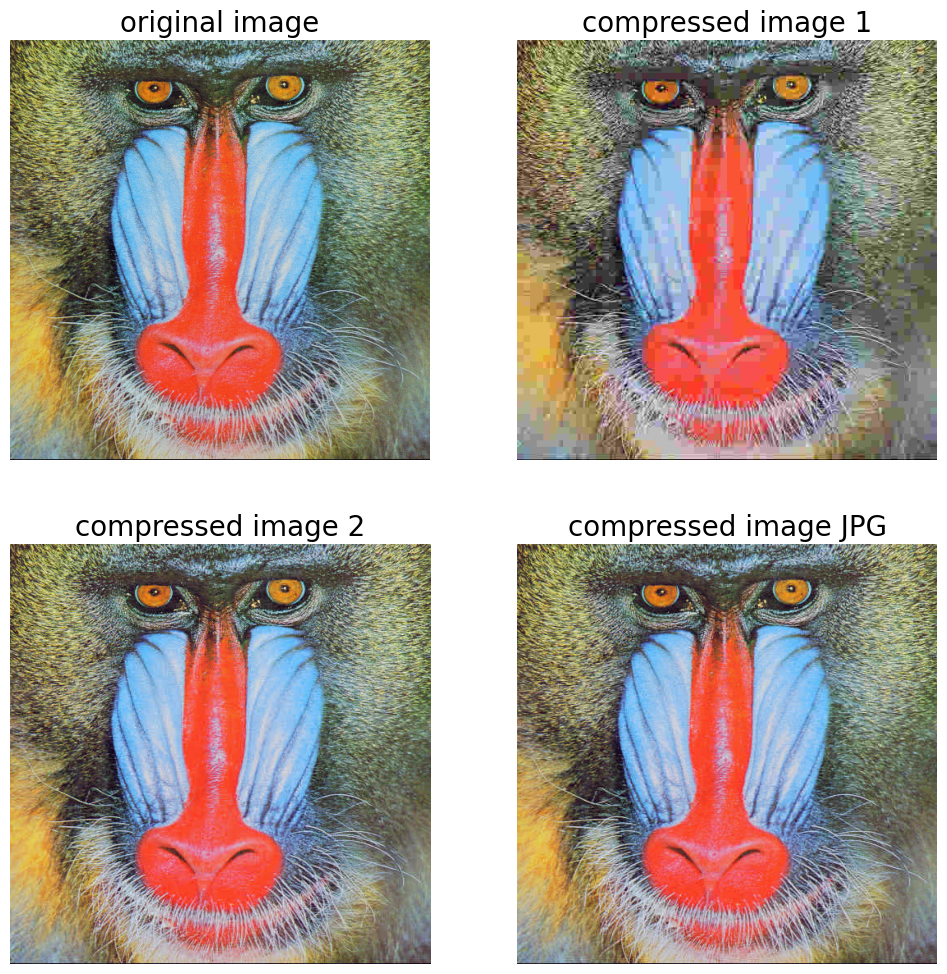

In [175]:
plt.figure(figsize=(12,12))
plt.subplot(221)
plt.imshow(img)
plt.axis('off')
plt.title('original image', size=20)

plt.subplot(222)
plt.imshow(new_1)
plt.axis('off')
plt.title('compressed image 1', size=20)

plt.subplot(223)
plt.imshow(new_2)
plt.axis('off')
plt.title('compressed image 2', size=20)

plt.subplot(224)
plt.imshow(new_jpeg)
plt.axis('off')
plt.title('compressed image JPG', size=20)
plt.show()



Guardar la imagen como binario con pickle

Ahora se busca comparar los resultados obtenidos con respecto a los que se optendrían con un Q de jpeg


In [ ]:
def calculate_psnr(img1, img2, max_value=255):
    """"Calculating peak signal-to-noise ratio (PSNR) between two images."""
    mse = np.mean((np.array(img1, dtype=np.float32) - np.array(img2, dtype=np.float32)) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(max_value / (np.sqrt(mse)))

Tamaño de la imagen original: 786598 bytes
Tamaño de la imagen comprimida con q1: 786598 bytes
Tamaño de la imagen comprimida con q2: 786598 bytes
Tamaño de la imagen comprimida con jpeg: 786598 bytes
La imagen base se ve así:
[[[160 143  53]
  [ 61  67  44]
  [ 73  42  39]
  ...
  [132 126  59]
  [137 173  89]
  [180 189 117]]

 [[106 125  60]
  [142  90  33]
  [ 73  28  31]
  ...
  [108 137 106]
  [132 156 150]
  [133 138  59]]

 [[114  84  44]
  [115 113  53]
  [ 51  41  41]
  ...
  [113 101  84]
  [ 85  85  75]
  [ 85  84  46]]

 ...

 [[132 156 150]
  [111 161 159]
  [132 156 150]
  ...
  [113  70  72]
  [ 85  85  75]
  [ 85  84  46]]

 [[111 161 159]
  [132 156 150]
  [106 138 148]
  ...
  [ 85  85  75]
  [ 83  70  71]
  [ 83  70  71]]

 [[ 13   8  17]
  [ 13   8  17]
  [ 13   8  17]
  ...
  [ 13   8  17]
  [ 13   8  17]
  [ 13   8  17]]]
La imagen transformada se ve así:
[[[132 116  86]
  [110  93  63]
  [ 43  26   0]
  ...
  [162 175 135]
  [188 201 161]
  [192 205 165]]

 [[13

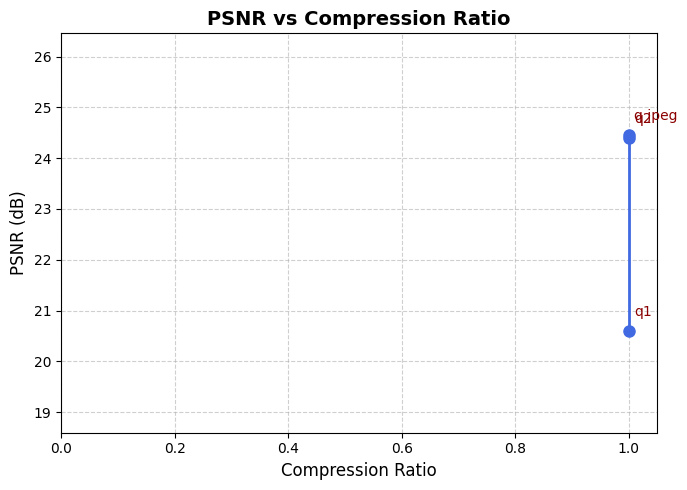

In [ ]:
import os
newrgb1_size = os.path.getsize("compressed_image1.pkl")
newrgb2_size = os.path.getsize("compressed_image2.pkl")
original_size = os.path.getsize("original_image.pkl")
jpg_size = os.path.getsize("jpg_image.pkl")
print(f"Tamaño de la imagen original: {original_size} bytes")
print(f"Tamaño de la imagen comprimida con q1: {newrgb1_size} bytes")
print(f"Tamaño de la imagen comprimida con q2: {newrgb2_size} bytes")
print(f"Tamaño de la imagen comprimida con jpeg: {jpg_size} bytes")


new_q1_ratio = original_size/newrgb1_size
new_q2_ratio = original_size/newrgb2_size
jpg_ratio = original_size/jpg_size

ratio = [new_q1_ratio, new_q2_ratio, jpg_ratio]

new_q1_psnr = calculate_psnr(img, new_1)
new_q2_psnr = calculate_psnr(img, new_2)
jpg_psnr = calculate_psnr(img, new_jpeg)


print(f"PSNR de la imagen comprimida con q1: {new_q1_psnr}")
print(f"PSNR de la imagen comprimida con q2: {new_q2_psnr}")
print(f"PSNR de la imagen comprimida con jpeg: {jpg_psnr}")

psnr = [new_q1_psnr, new_q2_psnr, jpg_psnr]


labels = ['q1','q2', 'q jpeg']

plt.figure(figsize=(7, 5))
plt.plot(ratio, psnr, 'o-', color='royalblue', linewidth=2, markersize=8)
plt.title("PSNR vs Compression Ratio", fontsize=14, fontweight='bold')
plt.xlabel("Compression Ratio", fontsize=12)
plt.ylabel("PSNR (dB)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Etiquetas para cada punto
for i, label in enumerate(labels):
    plt.text(ratio[i] + 0.01, psnr[i] + 0.3, label,
             fontsize=10, color='darkred')

# Ajustes de ejes
plt.xlim(0, 1.05)
plt.ylim(min(psnr) - 2, max(psnr) + 2)

plt.tight_layout()
plt.show()

Ahora para buscar un valor de q que comprima la imagen de manera eficiente haremos muchas pruebas aleatorias

2. Image recognition: Digit recognition
    1. Direct Image classification
        1. Load the dataset and display some images
        1. Use the whole image as features to train and test some basics ML methods (from scikit-learn). Display results and comment.

    1. Image features
        1. Choose one PPM image and compute the HOG (Histogram of Gradient Feature, first introduced by Dalal and Triggs in 2005 as a robust feature extraction method), `hog_feature, hog_image = feature.hog(img, visualize=True)`, display the `hog_feature` as histogram and `hog_image` as image. Your image is in color so you should use `channel_axis=2`. As default parameters you can use: `pixels_per_cell=(16, 16), cells_per_block=(1, 1)`.
        HOG features can be seen as edge descriptors computed by bloc and then aggregated into an histogram.
        1. Use HOG features for the images and classify using the same set up.
        1. Suppose we compress the test dataset (with JPEG QF=75), and classify using the same set up, what can we expect?  

In [ ]:
from sklearn.datasets import fetch_openml
import pandas as pd

In [ ]:
mnist = fetch_openml('mnist_784')

In [ ]:
X, y = mnist["data"], mnist["target"]

# Split into train and test sets
X_train, X_test = np.array(X[:60000],dtype=np.uint8), np.array(X[60000:],dtype=np.uint8)
y_train, y_test = np.array(y[:60000],dtype=np.uint8), np.array(y[60000:],dtype=np.uint8)

In [ ]:
def display_image(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

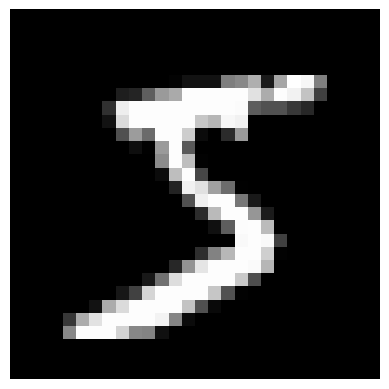

np.uint8(5)

In [ ]:
display_image(X_train[0])
y_train[0]

3. Photographic mosaic. The idea is to generate a large mosaic image from a large database of small images called thumbnails. The principle of the method consists of taking a large image, cutting it into small blocks, and replacing each block of the large image with the most similar thumbnail from the large thumbnail database. https://en.wikipedia.org/wiki/Photographic_mosaic
    1. Chose a large image
    1. Get a large image dataset from internet
    1. Split your image into blocs. What is a good bloc size?
    1. Compute a criteria for each bloc (first try the mean value), it will be used to match with thumbnails
    1. Display the bloc image, where each bloc of the image is replaced by the criteria
    1. Generate the mosaic by replacing each bloc of the image by the resized image that minimize the distance between their critaria values
    1. What criteria could be used instead? With witch distance? Try it!